Data extraction from various sources 

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

search_query_list = ["DMT Dimethyltryptamine", "Psilocybin mushrooms", "MDMA", "psychedelics therapy and mental health", "LSD", "hallucinogens", "consciousness and psychedelics"]
articles_data = []

for search_query in search_query_list:
    for page in range(7):
        url = f"https://pubmed.ncbi.nlm.nih.gov/?term={search_query}&page={page}"
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")
        articles = soup.find_all("div", {"class": "docsum-content"})
        
        for article in articles:
            title_element = article.find("a", {"class": "docsum-title"})
            title = title_element.text.strip()
            authors = [a.text for a in article.find_all("span", {"class": "docsum-authors"})]
            pmid = article.find("span", {"class": "docsum-pmid"}).text.strip()

            abstract_element = article.find("div", {"class": "short-view-snippet"})
            if abstract_element is not None:
                abstract_url = "https://pubmed.ncbi.nlm.nih.gov" + title_element['href']
                abstract_response = requests.get(abstract_url)
                abstract_soup = BeautifulSoup(abstract_response.content, "html.parser")
                abstract_element = abstract_soup.find("div", {"class": "abstract-content selected"})
                if abstract_element is not None:
                    abstract = abstract_element.text.strip()
                else:
                    abstract = "No abstract available"
            else:
                abstract = "No abstract available"

            doi_element = article.find("span", {"class": "docsum-journal-citation full-journal-citation"})
            if doi_element is not None:
                doi_pattern = r'doi:\s(\S+)'
                doi_match = re.search(doi_pattern, doi_element.text)
                doi = doi_match.group(1) if doi_match else "No DOI available"

                date_pattern = r'\d{4}\s\w+\s\d+'
                date_match = re.search(date_pattern, doi_element.text)
                date = date_match.group() if date_match else "No date available"
            else:
                doi = "No DOI available"
                date = "No date available"

           
            articles_data.append({'Keyword': search_query, 'Title': title, 'Authors': authors, 'PMID': pmid, 'Abstract': abstract, 'DOI': doi, 'Date': date})
            # articles_data.append({'Search Query': search_query, 'Title': title, 'Authors': authors, 'PMID': pmid, 'Abstract': abstract, 'Published Date': published_date})

# Save the extracted data to an Excel file
df_pub = pd.DataFrame(articles_data)
df_pub.to_excel("C:/Users/61430/Desktop/Masters in Data Science/MA5851 - Master Class1/Assessment 3/Solutions and attempts/Excel files/PubMed/articles_pub.xlsx", index=False)

Scopus Web crawler 

In [8]:
import requests
import json
import pandas as pd


article_data_raw = []

# Set up the API endpoint and parameters
base_url = 'https://api.elsevier.com/content/search/scopus'
# base_url = 'https://api.elsevier.com/content/search/scopus?sort=relevance'

query_params = {

    'query': '',
    'count': '10',
    'view': 'COMPLETE'
}

# List of keywords to search
keywords = ["psychedelics mental health", "MDMA", "psilocybin mushrooms","DMT Dimethyltryptamine", "LSD", "hallucinogens altered states mental health", "psychedelic therapy PTSD"]

# Iterate through each keyword in the list
for keyword in keywords:
    # base_url = f'https://api.elsevier.com/content/search/scopus?query={keyword}+AND+pub-date+IS+AFTER+1950-01-01'
    # Set the query parameter to the current keyword
    query_params['query'] = keyword

    # Iterate through the first 5 pages of search results
    for page in range(5):
        # Set the start parameter to retrieve the next page of search results
        query_params['start'] = str(page * int(query_params['count']))

        # Make the API request
        response = requests.get(base_url, params=query_params)

        # Convert the response to JSON format
        response_json = response.json()

        # Extract article data from the JSON response
        for article in response_json['search-results']['entry']:
            title = article.get('dc:title', 'No title available')
            
            if article.get('author') is not None:
                authors = [f"{author.get('surname', '')}, {author.get('given-name', '')}" for author in article['author']]
            else:
                authors = ['No information about authors']
            
            publish_date = article.get('prism:coverDate')
            doi = article.get('prism:doi')
            summary = article.get('dc:description', 'No description available')

            article_info = {'Keyword': keyword, 'Title': title, 'Authors': authors, 'Abstract': summary, 'DOI': doi, "Date": publish_date}

            article_data_raw.append(article_info)


df_scopus = pd.DataFrame(article_data_raw)
df_scopus.to_excel('C:/Users/61430/Desktop/Masters in Data Science/MA5851 - Master Class1/Assessment 3/Solutions and attempts/Excel files/Scholar/articles_scopus.xlsx', index=False)


In [15]:
# Load saved data to avoid calls to API
import pandas as pd

df_pub = pd.read_excel('C:/Users/61430/Desktop/Masters in Data Science/MA5851 - Master Class1/Assessment 3/Solutions and attempts/Excel files/PubMed/articles_pub.xlsx')
df_scopus = pd.read_excel('C:/Users/61430/Desktop/Masters in Data Science/MA5851 - Master Class1/Assessment 3/Solutions and attempts/Excel files/Scholar/articles_scopus.xlsx')

In [16]:
# Removing all duplicates PMID articles
df_pub = df_pub.drop_duplicates(subset=['PMID'])

# Removing all duplicates from Scopus with duplicate DOI
df_scopus = df_scopus.drop_duplicates(subset=['DOI'])

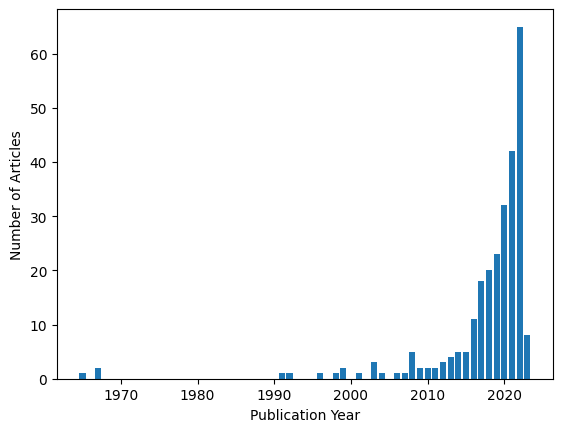

In [10]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Extract the publication year from the Date column
df_pub['Year'] = df_pub['Date'].apply(lambda x: datetime.strptime(x, '%Y %b %d').year if x != 'No date available' else 'No date available')

# Create a bar chart of the publication years
if 'No date available' in df_pub['Year'].values:
    year_counts = df_pub[df_pub['Year'] != 'No date available']['Year'].value_counts().sort_index()
else:
    year_counts = df_pub['Year'].value_counts().sort_index()

fig, ax = plt.subplots()
ax.bar(year_counts.index, year_counts.values)
ax.set_xlabel('Publication Year')
ax.set_ylabel('Number of Articles')
plt.show()

C:\Users\61430\AppData\Local\Temp\ipykernel_13044\1664863332.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'No date available' in df_scopus[['Year', 'Month']].values:


Text(0, 0.5, 'Number of Articles')

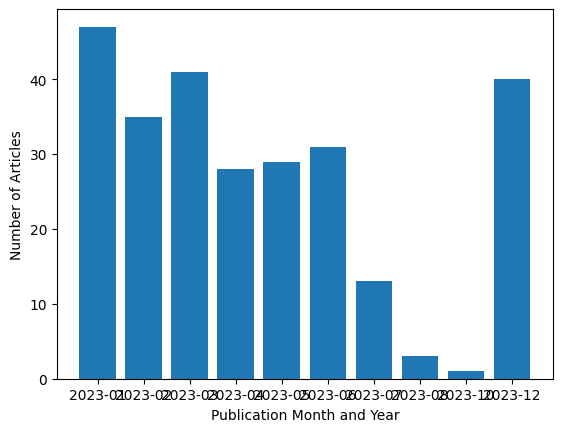

In [22]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Extract the publication year and month from the Date column
df_scopus['Year'] = df_scopus['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').year if x != 'No date available' else 'No date available')
df_scopus['Month'] = df_scopus['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').month if x != 'No date available' else 'No date available')

# Create a bar chart of the publication months
if 'No date available' in df_scopus[['Year', 'Month']].values:
    month_counts = df_scopus[(df_scopus['Year'] != 'No date available') & (df_scopus['Month'] != 'No date available')].groupby(['Year', 'Month']).size().reset_index(name='count')
else:
    month_counts = df_scopus.groupby(['Year', 'Month']).size().reset_index(name='count')

# modify month_tuples to be a list of strings
month_tuples = [f"{y}-{m:02d}" for y, m in month_counts[['Year', 'Month']].values]
# month_tuples = [tuple(x) for x in month_counts[['Year', 'Month']].values]
month_values = month_counts['count'].values

# plot the bar chart
fig, ax = plt.subplots()
ax.bar(month_tuples, month_values)
ax.set_xlabel('Publication Month and Year')
ax.set_ylabel('Number of Articles')


In [23]:
raw_data = pd.concat([df_scopus, df_pub], axis=0)

In [77]:
raw_data.shape

(645, 9)

In [25]:
raw_data.head()

,Keyword,Title,Authors,Abstract,DOI,Date,Year,Month,PMID
0,psychedelics mental health,"Molecular Structure, Reactivity and Spectrosco...","['Saminathan, Gomathi', 'Kandasamy, Kavitha', ...",Medical hallucinogens have been important comp...,10.33263/LIANBS124.105,2023-12-30,2023.0,12.0,NaN
1,psychedelics mental health,Eating disorder patients with and without PTSD...,"['Brewerton, Timothy D.', 'Gavidia, Ismael', '...",Introduction: We studied whether provisional p...,10.1186/s40337-023-00773-4,2023-12-01,2023.0,12.0,NaN
2,psychedelics mental health,Palliative care in severe mental illnesses,"['Masel, Eva Katharina', 'Antunes, Bárbara', '...","In this editorial, we highlight the interactio...",10.1186/s12904-023-01152-1,2023-12-01,2023.0,12.0,NaN
3,psychedelics mental health,Past Is Prologue: ethical issues in pediatric ...,"['Edelsohn, Gail A.', 'Sisti, Dominic']",Recent clinical trials of psychedelic drugs ai...,10.1353/pbm.2023.0007,2023-12-01,2023.0,12.0,NaN
4,psychedelics mental health,A national population-based study of cannabis ...,"['Zaman, Tauheed', 'Bravata, Dawn M.', 'Byers,...",Background: Cannabis is marketed as a treatmen...,10.1186/s12888-023-04648-5,2023-12-01,2023.0,12.0,NaN


In [26]:
count = len(raw_data[raw_data['Abstract'] != 'No abstract available'])
count

597

597 entries in the raw data contain any Abstract summary for the article and are others are discarded as they dont provide any structural information to the model.

In [27]:
df = raw_data.loc[raw_data['Abstract'] != 'No abstract available']

In [28]:
# Another check to see if both DataSources generated similar articles
df = df.drop_duplicates(subset=['DOI'])

In [29]:
df.shape

(582, 9)

In [30]:
import pandas as pd
import datetime

# Define the date formats to try
formats = ['%Y %b %d', '%Y-%m-%d']

# Define a function to convert the date to the desired format
def convert_date(date_string):
    for format_string in formats:
        try:
            date_obj = datetime.datetime.strptime(date_string, format_string)
            return date_obj.strftime('%Y-%m-%d')
        except ValueError:
            pass
    return 'No date available'

# Apply the convert_date function to the 'Date' column using the apply method
df['Date'] = df['Date'].apply(convert_date)


Before Data Cleaning.

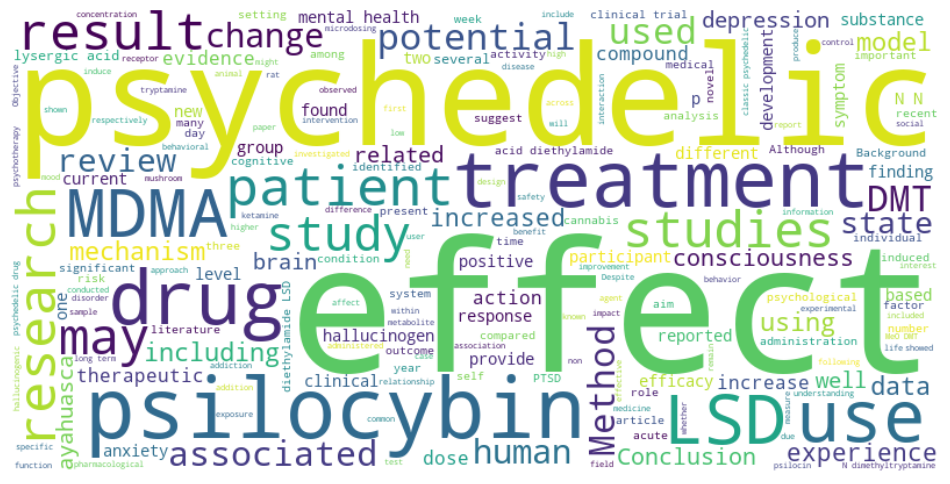

In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming your dataframe is called "df" and the column with abstracts is "Abstract"
abstracts = ' '.join(df['Abstract'].astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(abstracts)

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

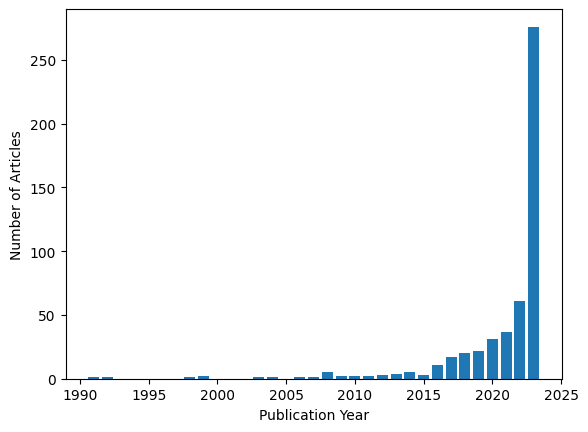

In [32]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Extract the publication year from the Date column
df['Year'] = df['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').year if x != 'No date available' else 'No date available')

# Create a bar chart of the publication years
if 'No date available' in df['Year'].values:
    year_counts = df[df['Year'] != 'No date available']['Year'].value_counts().sort_index()
else:
    year_counts = df['Year'].value_counts().sort_index()

fig, ax = plt.subplots()
ax.bar(year_counts.index, year_counts.values)
ax.set_xlabel('Publication Year')
ax.set_ylabel('Number of Articles')
plt.show()


In [33]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download stopwords and lemmatizer data
# nltk.data.path.append('C:/Users/61430/AppData/Local/Packages/PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0/LocalCache/local-packages/Python310/site-packages/nltk')
# nltk.download('stopwords')
# nltk.download('wordnet')

def clean_text(text):
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    
    # Convert text to lowercase
    text = text.lower()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    clean_words = [word for word in words if word.casefold() not in stop_words]
    clean_text = ' '.join(clean_words)

    # Lemmatize text
    lemmatizer = WordNetLemmatizer()
    words = nltk.word_tokenize(clean_text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    clean_text = ' '.join(lemmatized_words)

    return clean_text

In [34]:
df['Cleaned_Abstract'] = df['Abstract'].apply(lambda x: clean_text(x))

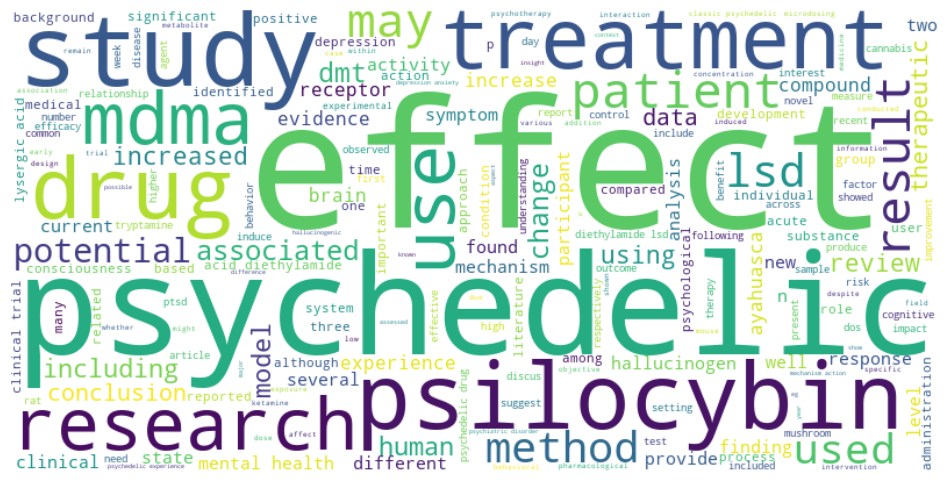

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming your dataframe is called "df" and the column with abstracts is "Abstract"
abstracts = ' '.join(df['Cleaned_Abstract'].astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(abstracts)

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [36]:
import pandas as pd
import nltk
nltk.download('punkt')

# Tokenize the Cleaned_Abstract column
df['tokens'] = df['Cleaned_Abstract'].apply(lambda x: nltk.word_tokenize(x))

# Print the DataFrame with the tokenized data
# print(df)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\61430\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [37]:
df.head()

,Keyword,Title,Authors,Abstract,DOI,Date,Year,Month,PMID,Cleaned_Abstract,tokens
0,psychedelics mental health,"Molecular Structure, Reactivity and Spectrosco...","['Saminathan, Gomathi', 'Kandasamy, Kavitha', ...",Medical hallucinogens have been important comp...,10.33263/LIANBS124.105,2023-12-30,2023,12.0,NaN,medical hallucinogen important compound resear...,"[medical, hallucinogen, important, compound, r..."
1,psychedelics mental health,Eating disorder patients with and without PTSD...,"['Brewerton, Timothy D.', 'Gavidia, Ismael', '...",Introduction: We studied whether provisional p...,10.1186/s40337-023-00773-4,2023-12-01,2023,12.0,NaN,introduction studied whether provisional postt...,"[introduction, studied, whether, provisional, ..."
2,psychedelics mental health,Palliative care in severe mental illnesses,"['Masel, Eva Katharina', 'Antunes, Bárbara', '...","In this editorial, we highlight the interactio...",10.1186/s12904-023-01152-1,2023-12-01,2023,12.0,NaN,editorial highlight interaction patient diagno...,"[editorial, highlight, interaction, patient, d..."
3,psychedelics mental health,Past Is Prologue: ethical issues in pediatric ...,"['Edelsohn, Gail A.', 'Sisti, Dominic']",Recent clinical trials of psychedelic drugs ai...,10.1353/pbm.2023.0007,2023-12-01,2023,12.0,NaN,recent clinical trial psychedelic drug aim tre...,"[recent, clinical, trial, psychedelic, drug, a..."
4,psychedelics mental health,A national population-based study of cannabis ...,"['Zaman, Tauheed', 'Bravata, Dawn M.', 'Byers,...",Background: Cannabis is marketed as a treatmen...,10.1186/s12888-023-04648-5,2023-12-01,2023,12.0,NaN,background cannabis marketed treatment pain li...,"[background, cannabis, marketed, treatment, pa..."


In [38]:
cleaned_abstracts_list = df["Cleaned_Abstract"].tolist()
print(cleaned_abstracts_list)

['medical hallucinogen important compound research interest recent year computational chemistry method like density functional theory dft calculation level carried get insight structural preference mechanism hallucinogen like psilocybin mescaline derivative molecular level molecular structure reactivity spectroscopic property mechanism hallucination confirm geometry molecule crucial preferred action result show ability compound derivative act drug different problem among compound studied compound except tin lead derivative show considerable stability synthesizing laboratory geometry reactivity descriptor important tool deciding activity magic mushroom', 'introduction studied whether provisional posttraumatic stress disorder ptsd moderated discharge dc followup fu outcome multimodal integrated eating disorder ed residential treatment rt based upon principle cognitive processing therapy cpt method ed patient n female mean age sd year lgbtq without ptsd completed validated assessment admi

In [34]:
pip install spacy

                                              0.0/12.2 MB ? eta -:--:--
                                             0.0/12.2 MB 991.0 kB/s eta 0:00:13
                                             0.1/12.2 MB 991.0 kB/s eta 0:00:13
                                              0.1/12.2 MB 1.0 MB/s eta 0:00:12
                                              0.2/12.2 MB 1.1 MB/s eta 0:00:11
                                              0.2/12.2 MB 1.1 MB/s eta 0:00:11
     -                                        0.3/12.2 MB 1.1 MB/s eta 0:00:11
     -                                        0.4/12.2 MB 1.1 MB/s eta 0:00:11
     -                                        0.4/12.2 MB 1.2 MB/s eta 0:00:10
     -                                        0.5/12.2 MB 1.2 MB/s eta 0:00:11
     -                                        0.5/12.2 MB 1.1 MB/s eta 0:00:11
     -                                        0.6/12.2 MB 1.2 MB/s eta 0:00:10
     --                                       0.6/12.2 MB

In [ ]:
!pip install --upgrade setuptools
!pip install --upgrade pip
!pip install --use-pep517 gensim==3.8.3


In [79]:
pip install --upgrade gensim

                                              0.0/24.0 MB ? eta -:--:--
                                              0.0/24.0 MB 1.3 MB/s eta 0:00:19
                                             0.1/24.0 MB 975.2 kB/s eta 0:00:25
                                             0.1/24.0 MB 930.9 kB/s eta 0:00:26
                                             0.1/24.0 MB 944.1 kB/s eta 0:00:26
                                             0.2/24.0 MB 981.9 kB/s eta 0:00:25
                                              0.3/24.0 MB 1.1 MB/s eta 0:00:22
                                              0.4/24.0 MB 1.1 MB/s eta 0:00:22
                                              0.4/24.0 MB 1.2 MB/s eta 0:00:20
                                              0.5/24.0 MB 1.2 MB/s eta 0:00:20
                                              0.5/24.0 MB 1.2 MB/s eta 0:00:20
     -                                        0.6/24.0 MB 1.2 MB/s eta 0:00:20
     -                                        0.6/24.0 

In [39]:
# import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
# !pip install gensim==3.8.3
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

import nltk
from nltk.stem import WordNetLemmatizer 

# Plotting tools
# !pip install pyLDAvis
import pyLDAvis
from pyLDAvis import gensim_models
#import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

# !pip install wordcloud
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

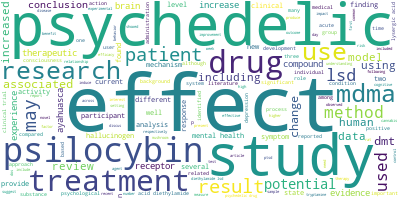

In [40]:
long_string = ','.join(list(df['Cleaned_Abstract'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [41]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'ax', 'posting', 'article'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\61430\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
# Convert to list
data = df.Cleaned_Abstract.values.tolist()

# Remove Emails
# data = [re.sub('[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+.[A-Z|a-z]{2,}', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('(\n|\r)+', ' ', sent) for sent in data]

# Remove single quotes
# data = [re.sub("\'", "", sent) for sent in data]

pprint(data[1:2])

['introduction studied whether provisional posttraumatic stress disorder ptsd '
 'moderated discharge dc followup fu outcome multimodal integrated eating '
 'disorder ed residential treatment rt based upon principle cognitive '
 'processing therapy cpt method ed patient n female mean age sd year lgbtq '
 'without ptsd completed validated assessment admission adm dc fu measure '
 'severity ed ptsd major depressive disorder mdd statetrait anxiety sta '
 'symptom eating disorder quality life edqol tested whether ptsd moderated '
 'course symptom change using mixed model analysis ed diagnosis adm bmi age ed '
 'onset lgbtq orientation significant covariates change number day adm fu used '
 'weighting measure result despite sustained improvement rt total group ptsd '
 'group significantly higher score measure time point p patient n without ptsd '
 'n showed similar symptom improvement adm dc outcome remained statistically '
 'improved fu compared adm significant worsening observed dc fu mdd

In [43]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))  # deacc = True removes punctuations

data_words = list(sent_to_words(data))
# print(data_words)
print(data_words[1:2])

[['introduction', 'studied', 'whether', 'provisional', 'posttraumatic', 'stress', 'disorder', 'ptsd', 'moderated', 'discharge', 'dc', 'followup', 'fu', 'outcome', 'multimodal', 'integrated', 'eating', 'disorder', 'ed', 'residential', 'treatment', 'rt', 'based', 'upon', 'principle', 'cognitive', 'processing', 'therapy', 'cpt', 'method', 'ed', 'patient', 'female', 'mean', 'age', 'sd', 'year', 'lgbtq', 'without', 'ptsd', 'completed', 'validated', 'assessment', 'admission', 'adm', 'dc', 'fu', 'measure', 'severity', 'ed', 'ptsd', 'major', 'depressive', 'disorder', 'mdd', 'statetrait', 'anxiety', 'sta', 'symptom', 'eating', 'disorder', 'quality', 'life', 'edqol', 'tested', 'whether', 'ptsd', 'moderated', 'course', 'symptom', 'change', 'using', 'mixed', 'model', 'analysis', 'ed', 'diagnosis', 'adm', 'bmi', 'age', 'ed', 'onset', 'lgbtq', 'orientation', 'significant', 'covariates', 'change', 'number', 'day', 'adm', 'fu', 'used', 'weighting', 'measure', 'result', 'despite', 'sustained', 'improve

In [44]:
bigram = gensim.models.Phrases(data_words, min_count=2, delimiter=' ')
trigram = gensim.models.Phrases(bigram[data_words], min_count=1, delimiter=' ')

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [45]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [46]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Form Bigrams
data_words_bigrams = make_bigrams(data_lemmatized)

# Form Trigrams
data_words_trigrams = make_trigrams(data_lemmatized)

print(data_words_bigrams[:1])
print(data_words_trigrams[:1])

[['medical', 'hallucinogen', 'important', 'compound', 'research', 'interest', 'recent year', 'computational', 'chemistry', 'method', 'density', 'functional', 'theory', 'calculation', 'level', 'carry', 'get', 'insight', 'structural', 'preference', 'mechanism', 'hallucinogen', 'derivative', 'molecular', 'level', 'molecular', 'structure', 'reactivity', 'spectroscopic', 'property', 'mechanism', 'hallucination', 'confirm', 'geometry', 'molecule', 'crucial', 'preferred', 'action', 'result show', 'ability', 'compound', 'derivative', 'act', 'drug', 'different', 'problem', 'compound', 'study', 'compound', 'tin', 'lead', 'derivative', 'show', 'considerable', 'stability', 'synthesize', 'laboratory', 'geometry', 'reactivity', 'descriptor', 'important', 'tool', 'decide', 'activity', 'magic mushroom']]
[['medical', 'hallucinogen', 'important', 'compound', 'research', 'interest', 'recent year', 'computational', 'chemistry', 'method', 'density functional', 'theory', 'calculation', 'level', 'carry', 'g

In [47]:
print(len(data_words_bigrams))

582


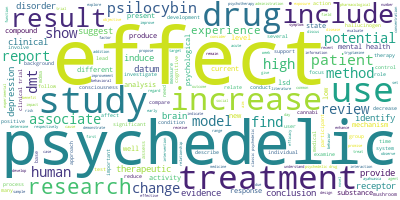

In [48]:
from itertools import chain
long_string = ",".join(list(chain.from_iterable(data_words_bigrams)))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

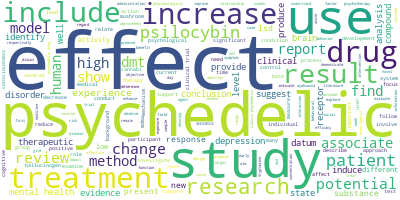

In [49]:
from itertools import chain
long_string = ",".join(list(chain.from_iterable(data_lemmatized)))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

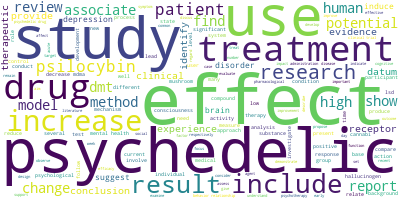

In [50]:
from itertools import chain
long_string = ",".join(list(chain.from_iterable(data_words_trigrams)))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [51]:
# View bigram and trigram words
my_bigrams = []
my_trigrams = []
for sent in data_lemmatized:
    bigrams_ = [b for b in bigram_mod[sent] if b.count(' ') == 1]
    trigrams_ = [t for t in trigram_mod[bigram[sent]] if t.count(' ') == 2]
    if (len(bigrams_)>0):
      my_bigrams.append(bigrams_)
      print(bigrams_)
    if(len(trigrams_)>0):
      my_trigrams.append(trigrams_)
      print(trigrams_)

['recent year', 'result show', 'magic mushroom']
['posttraumatic stress', 'cognitive processing', 'mean age', 'major depressive', 'mixed model', 'sustained improvement', 'group group', 'time point', 'symptom improvement', 'time interaction', 'quality life', 'sustained improvement', 'future work']
['posttraumatic stress disorder', 'female mean age', 'major depressive disorder']
['mental illness', 'palliative care']
['severe mental illness']
['clinical trial', 'psychedelic drug', 'psychiatric condition', 'breakthrough therapy', 'posttraumatic stress', 'depression trd', 'potential benefit', 'child adolescent', 'psychedelic experience', 'psychedelic experience', 'personality change', 'traumatic memory']
['recent clinical trial', 'range psychiatric condition']
['prevalence cannabis', 'crosssectional study', 'primary care', 'prevalence cannabis', 'positive udt', 'logistic regression', 'mental health', 'cannabis positive', 'prevalence cannabis', 'positive udt', 'medical recreational', 'medica

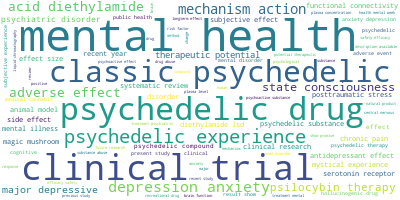

In [52]:
from itertools import chain
long_string = ",".join(list(chain.from_iterable(my_bigrams)))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

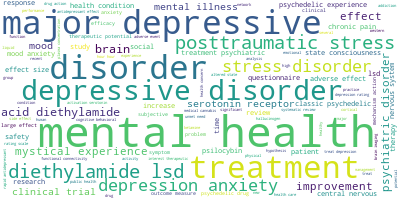

In [53]:
from itertools import chain
long_string = ",".join(list(chain.from_iterable(my_trigrams)))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [54]:
#LDA topic model requires two things: the dictionary(id2word) and the corpus
# Create Dictionary
id2word = corpora.Dictionary(my_bigrams) #data_words_bigrams

#filtering words less frequent and high frequent; taking only the top 100,000 keywords
id2word.filter_extremes(no_below=10, no_above=0.5, keep_n=100000)

# Create Corpus
texts = my_bigrams #data_words_bigrams

# Term Document Frequency (Bag of Words Approach)
corpus = [id2word.doc2bow(text) for text in texts]

In [55]:
# View
print(corpus[1:2])

[[(3, 1), (4, 1), (5, 1)]]


In [56]:
# readable format of corpus (term-frequency) in a sentence
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[1:2]]

[[('major depressive', 1), ('posttraumatic stress', 1), ('quality life', 1)]]

In [57]:
%%time
# Building the topic model - LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=1001,
                                           update_every=1,
                                           chunksize=100,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)

CPU times: total: 1.28 s
Wall time: 1.9 s


In [58]:
%%time
# Print the Keywords in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.410*"depression anxiety" + 0.245*"major depressive" + 0.143*"anxiety '
  'depression" + 0.141*"public health" + 0.030*"quality life" + '
  '0.000*"mystical experience" + 0.000*"diethylamide lsd" + 0.000*"mood '
  'disorder" + 0.000*"show promise" + 0.000*"treatment mental"'),
 (1,
  '0.685*"clinical trial" + 0.148*"psychological support" + 0.129*"previous '
  'study" + 0.001*"mood disorder" + 0.001*"finding suggest" + 0.001*"show '
  'promise" + 0.001*"functional magnetic" + 0.001*"brain function" + '
  '0.001*"treatment mental" + 0.001*"potential therapeutic"'),
 (2,
  '0.334*"psychedelic substance" + 0.321*"systematic review" + 0.173*"safety '
  'efficacy" + 0.128*"treatment option" + 0.001*"treatment mental" + '
  '0.001*"brain function" + 0.001*"show promise" + 0.001*"mystical experience" '
  '+ 0.001*"mood disorder" + 0.001*"diethylamide lsd"'),
 (3,
  '0.951*"classic psychedelic" + 0.001*"mystical experience" + 0.001*"healthy '
  'volunteer" + 0.001*"potential therapeut

In [59]:
#Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
print('Done computing coherence score')


Perplexity:  -6.492594895552987

Coherence Score:  0.5441401872472262
Done computing coherence score


In [83]:
# !pip install pyldavis==2.1.2
# !pip install pandas==1.1.5
# !pip install pandas==1.3.3
# !pip install pyldavis --upgrade
!pip install pandas==1.2.5



  Using cached pandas-1.2.5.tar.gz (5.5 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: still running...
  Getting requirements to build wheel: still running...
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build pandas


  error: subprocess-exited-with-error
  
  × Building wheel for pandas (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [1566 lines of output]
      <string>:44: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-310
      creating build\lib.win-amd64-cpython-310\pandas
      copying pandas\conftest.py -> build\lib.win-amd64-cpython-310\pandas
      copying pandas\testing.py -> build\lib.win-amd64-cpython-310\pandas
      copying pandas\_testing.py -> build\lib.win-amd64-cpython-310\pandas
      copying pandas\_typing.py -> build\lib.win-amd64-cpython-310\pandas
      copying pandas\_version.py -> build\lib.win-amd64-cpython-310\pandas
      copying pandas\__init__.py -> build\lib.win-amd64-cpython-310\pandas
      creating build\lib.win-amd64-cpython-310\pandas\api
      copying pandas\api\__init

In [ ]:
!pip install --upgrade pyLDAvis

In [82]:
import pandas as pd
import pyLDAvis
import numpy as np

print('pandas version:', pd.__version__)
print('pyLDAvis version:', pyLDAvis.__version__)
print('numpy version:', np.__version__)


pandas version: 2.0.0
pyLDAvis version: 3.4.0
numpy version: 1.23.5


In [ ]:
import gensimvis
import gensim
from gensimvis.gensimvis import prepare

gensimvis.prepare(lda_model, corpus, dictionary)

In [79]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

TypeError: DataFrame.drop() takes from 1 to 2 positional arguments but 3 were given

In [ ]:
limit = 24
n_col = 4
counter = 0
num_topics = 20
topic_words = {}
plt.figure(figsize=(20, 16))
for ind in range(num_topics):

    title_str = "Topic{}".format(ind+1)
    topic_words[title_str] = {}
    t1 = lda_model.show_topic(ind,topn=200)
    i = 0
    word_freq = dict()
    for t,v in t1:
        if(v>0.0):
            word_freq[t] = v
            topic_words[title_str][i]=t
            i = i + 1

    wordcloud = WordCloud(background_color="white").fit_words(word_freq)

    plt.subplot(limit // n_col, n_col, counter + 1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title_str)
    # plt.close()

    counter += 1

In [ ]:
df = pd.DataFrame(topic_words)
df.to_csv("news_data_topic.csv", index=True)
df.head()

--------------

-------------------------- ERROR CODE

________________________-------------

This section possibly will come later


In [58]:
nltk.download("wordnet")
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

token_pattern = re.compile(r"(?u)\b\w\w+\b")


class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        return [
            self.wnl.lemmatize(t)
            for t in word_tokenize(doc)
            if len(t) >= 2 and re.match("[a-z].*", t) and re.match(token_pattern, t)
        ]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\61430\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [63]:
import time
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

vocab_size = 2000
print("Tokenizing and counting, this may take a few minutes...")
start_time = time.time()
vectorizer = CountVectorizer(
    input="content",
    analyzer="word",
    stop_words="english",
    tokenizer=LemmaTokenizer(),
    max_features=vocab_size,
    max_df=0.95,
    min_df=2,
)
vectors = vectorizer.fit_transform(cleaned_abstracts_list)
vocab_dict = vectorizer.vocabulary_
vocab_list = [word for word, idx in sorted(vocab_dict.items(), key=lambda x: x[1])]
print("vocab size:", len(vocab_list))

# random shuffle
idx = np.arange(vectors.shape[0])
np.random.shuffle(idx)
vectors = vectors[idx]

print("Done. Time elapsed: {:.2f}s".format(time.time() - start_time))


Tokenizing and counting, this may take a few minutes...
vocab size: 2000
Done. Time elapsed: 2.79s


In [64]:
threshold = 10
vectors = vectors[
    np.array(vectors.sum(axis=1) > threshold).reshape(
        -1,
    )
]
print("removed short docs (<{} words)".format(threshold))
print(vectors.shape)

removed short docs (<10 words)
(549, 2000)


In [65]:
print(type(vectors), vectors.dtype)
print(vectors[0])

<class 'scipy.sparse._csr.csr_matrix'> int64
  (0, 1105)	1
  (0, 1457)	4
  (0, 1599)	2
  (0, 1777)	1
  (0, 499)	1
  (0, 1896)	1
  (0, 1067)	2
  (0, 248)	2
  (0, 1220)	2
  (0, 1822)	2
  (0, 1873)	5
  (0, 774)	10
  (0, 1706)	1
  (0, 812)	1
  (0, 1649)	7
  (0, 1346)	2
  (0, 132)	1
  (0, 325)	1
  (0, 1686)	1
  (0, 1899)	3
  (0, 1505)	1
  (0, 46)	1
  (0, 1897)	3
  (0, 449)	6
  (0, 949)	1
  :	:
  (0, 654)	1
  (0, 528)	5
  (0, 1593)	5
  (0, 1504)	1
  (0, 1522)	1
  (0, 1828)	1
  (0, 1321)	2
  (0, 721)	1
  (0, 1110)	8
  (0, 162)	4
  (0, 1964)	1
  (0, 971)	1
  (0, 1170)	1
  (0, 595)	2
  (0, 1232)	2
  (0, 1806)	1
  (0, 881)	1
  (0, 468)	1
  (0, 749)	1
  (0, 794)	1
  (0, 1569)	2
  (0, 1514)	1
  (0, 1035)	4
  (0, 838)	1
  (0, 305)	1


In [66]:
import scipy.sparse as sparse

vectors = sparse.csr_matrix(vectors, dtype=np.float32)
print(type(vectors), vectors.dtype)

<class 'scipy.sparse._csr.csr_matrix'> float32


In [67]:
n_train = int(0.8 * vectors.shape[0])

# split train and test
train_vectors = vectors[:n_train, :]
test_vectors = vectors[n_train:, :]

# further split test set into validation set (val_vectors) and test  set (test_vectors)
n_test = test_vectors.shape[0]
val_vectors = test_vectors[: n_test // 2, :]
test_vectors = test_vectors[n_test // 2 :, :]

In [68]:
print(train_vectors.shape, test_vectors.shape, val_vectors.shape)

(439, 2000) (55, 2000) (55, 2000)
